In [1]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft2, irfft2
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

y, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None

with h5py.File("Z:\\files\\simulation_2d_compressed.h5", "r") as data:
    y = data["y"][:]
    Hs = data.attrs["Hs"]
    Tp = data.attrs["Tp"]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

index = 100
y = y[index:, 0, :, :].astype(np.complex64)

In [ ]:
eta_hat = y[:].copy()

modes = eta_hat.shape[-2] // 2
x = np.linspace(0, length, 2*modes)

X, Y = np.meshgrid(x, x)
mask = ((X-1500)**2+(Y-1500)**2) <= 200**2
mask_2 = ((X-1500)**2+(Y-1500)**2) < 1500**2

mask_i_left = []
mask_i_right = []
mask_i = []
mask_j = []

I, J = np.meshgrid(np.arange(0, 2*modes), np.arange(0, 2*modes))
for i in range(2*modes):
    for j in range(2*modes):
        if not mask[i, j]:
            continue

        for k in range(modes):
            if not mask[modes+k, j]:
                mask_i.append(i)
                mask_j.append(j)
                mask_i_left.append(modes+k)
                mask_i_right.append(modes-k-1)
                break

mask_2_i = []
mask_2_j = []
mask_2_i_map = []
mask_2_j_map = []
for j in range(2*modes):
    for i in range(modes):
        if mask_2[i, j]: continue
        for k in range(modes):
            if mask_2[i+k, j]:
                mask_2_i.append(i)
                mask_2_j.append(j)
                mask_2_i_map.append(i+k)
                mask_2_j_map.append(j)
                break

for j in range(2*modes):
    for i in range(modes, 2*modes):
        if mask_2[i, j]: continue
        for k in range(modes):
            if mask_2[i-k, j]:
                mask_2_i.append(i)
                mask_2_j.append(j)
                mask_2_i_map.append(i-k)
                mask_2_j_map.append(j)
                break

mask_i = np.array(mask_i)
mask_j = np.array(mask_j)
mask_i_left = np.array(mask_i_left)
mask_i_right = np.array(mask_i_right)

mask_2_i = np.array(mask_2_i)
mask_2_j = np.array(mask_2_j)
mask_2_i_map = np.array(mask_2_i_map)
mask_2_j_map = np.array(mask_2_j_map)

eta = irfft2(eta_hat).astype(np.float32)
eta[:, mask_i, mask_j] = (eta[:, mask_i_left, mask_j] + eta[:, mask_i_right, mask_j])*0.5
test[mask_2_i, mask_2_j] = test[mask_2_i_map, mask_2_j_map]
eta_hat = rfft2(eta).astype(np.complex64)

new_modes = 204
new_modes_hor = 100
indexes = np.concatenate((np.arange(0, modes+1), np.arange(2, modes+1)[::-1]))

mask_vert = indexes < new_modes_hor+1
mask_hor = np.arange(0, modes+1) < new_modes+1

eta_hat = eta_hat[:, mask_vert, :]
eta_hat = eta_hat[:, :, mask_hor] / modes / modes * new_modes_hor * new_modes

y = y[:, mask_vert, :]
y = y[:, :, mask_hor] / modes / modes * new_modes_hor * new_modes

In [3]:
prediction_time = 60 # 140 sec
measure_time = 60 # one minute
num_measurements = 6
step = int(measure_time / num_measurements)
train_percentage = 0.8

X = eta_hat[:-prediction_time].copy()
y = y[prediction_time+measure_time:-1]

X = irfft2(X)
y = irfft2(y)

X = np.stack([
    X[0*step:-measure_time+0*step-1],
    X[1*step:-measure_time+1*step-1],
    X[2*step:-measure_time+2*step-1],
    X[3*step:-measure_time+3*step-1],
    X[4*step:-measure_time+4*step-1],
    X[5*step:-measure_time+5*step-1],
    X[6*step:-measure_time+6*step-1],
], axis=1)

X_train = X[:int(X.shape[0]*train_percentage), :, :]
X_test = X[int(X.shape[0]*train_percentage):, :, :]
y_train = y[:int(y.shape[0]*train_percentage), :]
y_test = y[int(y.shape[0]*train_percentage):, :]

# Only need std to normalize

std = np.std(X_train)
X_train = X_train / std
y_train = y_train / std

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(624, 7, 200, 408) (624, 200, 408)
(156, 7, 200, 408) (156, 200, 408)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from FNO import FNO2d

device = torch.device("cuda")

val_mask = np.zeros(X_train.shape[0], dtype=bool)
val_mask[:int(0.1 * X_train.shape[0])] = True
np.random.shuffle(val_mask)

# to PyTorch tensors
X_t = torch.from_numpy(X_train[~val_mask]).float()
y_t = torch.from_numpy(y_train[~val_mask]).float()

X_v = torch.from_numpy(X_train[val_mask]).float()
y_v = torch.from_numpy(y_train[val_mask]).float()

dataset = TensorDataset(X_t, y_t)
loader  = DataLoader(dataset, batch_size=25, shuffle=True)

dataset_val = TensorDataset(X_v, y_v)
loader_val  = DataLoader(dataset_val, batch_size=25, shuffle=True)

model = FNO2d(in_channels=7, out_channels=1, width=16, modes_height=30, modes_width=150, depth=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

early_stopping_rounds = 10

early_stopping_count = 0
best_loss = np.inf

x = np.linspace(0, length, 2*new_modes_hor)
y = np.linspace(0, length, 2*new_modes)
X, Y = np.meshgrid(x, y, indexing="ij")
mask = ((X-1500)**2+(Y-1500)**2) <= 200**2
loss_mask = np.ones(y_train.shape[1:])
loss_mask[mask] = 3
loss_mask = torch.tensor(loss_mask, dtype=torch.float32).to(device)
loss_correction = 4 * modes * modes

model.train()
for epoch in range(1, 501):
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred * loss_mask, yb * loss_mask) * loss_correction / torch.sum(loss_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(loader)

    total_loss_val = 0.0
    for xb, yb in loader_val:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred * loss_mask, yb * loss_mask) * loss_correction / torch.sum(loss_mask)
        total_loss_val += loss.item()
    avg_val = total_loss / len(loader_val)

    if avg_val < best_loss:
        best_loss = avg_val
        early_stopping_count = 0
        torch.save(model.state_dict(), f"results/best_FNO_2d_circ_2.pt")
        print(f"Epoch: {epoch}, Loss train - {avg:.6f}, Loss val - {avg_val:.6f} - Saving")
    else:
        print(f"Epoch: {epoch}, Loss train - {avg:.6f}, Loss val - {avg_val:.6f}")
        early_stopping_count += 1
        if early_stopping_count > early_stopping_rounds:
            print("early_stopping")
            break

Epoch: 1, Loss train - 11.208547, Loss val - 85.932193 - Saving
Epoch: 2, Loss train - 3.041838, Loss val - 23.320760 - Saving
Epoch: 3, Loss train - 1.220608, Loss val - 9.357994 - Saving
Epoch: 4, Loss train - 0.988432, Loss val - 7.577975 - Saving
Epoch: 5, Loss train - 0.878922, Loss val - 6.738401 - Saving
Epoch: 6, Loss train - 0.797838, Loss val - 6.116756 - Saving
Epoch: 7, Loss train - 0.725393, Loss val - 5.561348 - Saving
Epoch: 8, Loss train - 0.661956, Loss val - 5.074997 - Saving
Epoch: 9, Loss train - 0.603944, Loss val - 4.630240 - Saving
Epoch: 10, Loss train - 0.551416, Loss val - 4.227521 - Saving
Epoch: 11, Loss train - 0.505075, Loss val - 3.872242 - Saving
Epoch: 12, Loss train - 0.462643, Loss val - 3.546931 - Saving
Epoch: 13, Loss train - 0.425712, Loss val - 3.263795 - Saving
Epoch: 14, Loss train - 0.393819, Loss val - 3.019277 - Saving
Epoch: 15, Loss train - 0.366492, Loss val - 2.809775 - Saving
Epoch: 16, Loss train - 0.343088, Loss val - 2.630340 - Savin

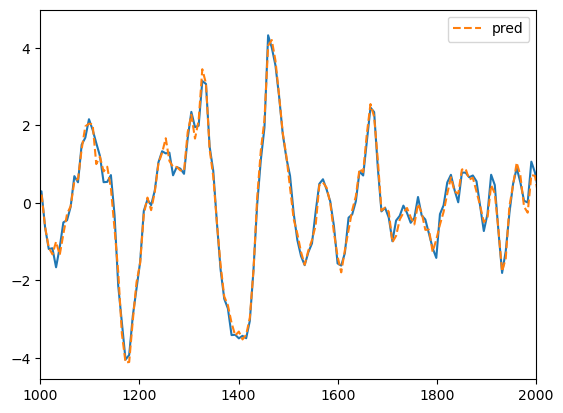

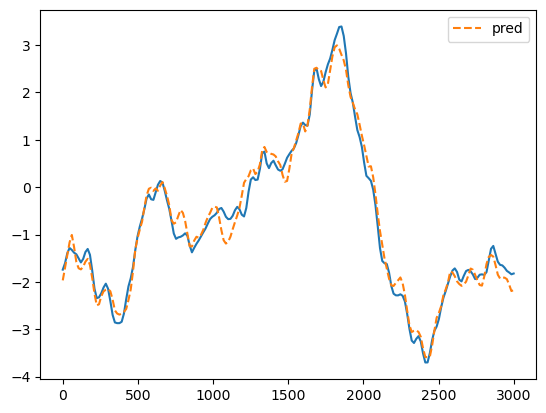

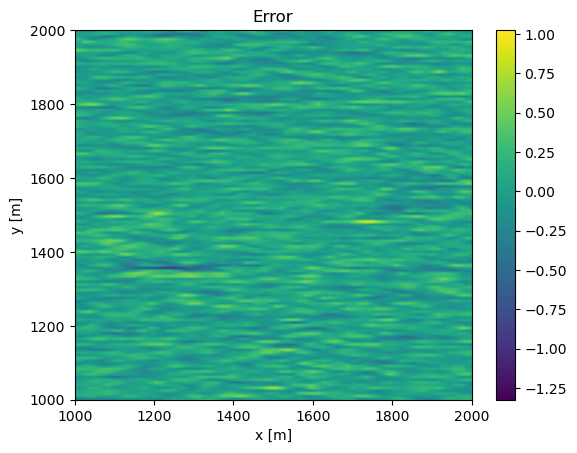

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from FNO import FNO1d, FNO2d

device = torch.device("cuda")
# model = FNO2d(in_channels=2, out_channels=1, width=16, modes_height=64, modes_width=64, depth=4)
# model.load_state_dict(torch.load("best_FNO.pt", map_location=device))
model.eval()

X_tensor = torch.from_numpy(X_test / std).float().to(device)
# random_indices = torch.randperm(X_tensor.shape[0])[:9]

y_pred = None
with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy() * std

error = y_pred - y_test

y = np.linspace(0, length, 2*new_modes)
x = np.linspace(0, length, 2*new_modes_hor)
plt.plot(np.linspace(0, length, 2*new_modes), y_test[0, new_modes_hor, :])
plt.plot(np.linspace(0, length, 2*new_modes), y_pred[0, new_modes_hor, :], "--", label="pred")
plt.xlim(1000, 2000)
plt.legend()
plt.show()

plt.plot(np.linspace(0, length, 2*new_modes_hor), y_test[0, :, new_modes])
plt.plot(np.linspace(0, length, 2*new_modes_hor), y_pred[0, :, new_modes], "--", label="pred")
plt.legend()
plt.show()


plt.contourf(x, y, error[0].transpose(), levels=100)
plt.colorbar()
plt.title("Error")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(1000, 2000)
plt.ylim(1000, 2000)
plt.show()

# for index in range(10):
#     plt.plot(x[mes_index_1:mes_index_2], y_pred[index, :, modes][mes_index_1:mes_index_2])
#     plt.plot(x, y_train[index, :, modes]*std_eta)
#     RMSE = np.sqrt(np.mean((y_pred[index, :, modes] - y_train[index, :, modes]*std_eta)**2))
#     plt.title(f"RMSE: {RMSE:.5f}m")
#     plt.show()

#     plt.plot(x, y_pred[index, modes, :])
#     plt.plot(x, y_train[index, modes, :]*std_eta)
#     RMSE = np.sqrt(np.mean((y_pred[index, modes, :] - y_train[index, modes, :]*std_eta)**2))
#     plt.title(f"RMSE: {RMSE:.5f}m")
#     plt.xlim(1000, 2000)
#     plt.show()